# Домашнее задание
Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами

Цель:
В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.


Описание/Пошаговая инструкция выполнения домашнего задания:
## [Часть 1. Парсинг](#part-1)
По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).
Идеальный датасет должен иметь текстовое описание некоторого объекта и некоторую целевую переменную, соответствующую этому объекту. Например:

Сайт новостей: текстовое описание - сама новость, целевая переменная - количество просмотров новости (можно поделить на число дней с момента даты публикации, чтобы получить “среднее число просмотров в день”).
Сайт с товарами/книгами/фильмами: текстовое описание товара/книги/фильма + средний рейтинг в качестве целевой переменной.
Блоги - тексты заметок + число просмотров.
И любые другие ваши идеи, которые подходят под такой формат.
Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.
Не забывайте, что парсинг - это ответственное мероприятие, поэтому не бомбардируйте несчастные сайты слишком частыми запросами (можно ограничить число запросов в секунду при помощи time.sleep(0.3), вставленного в теле цикла)

## [Часть 2. NLP](#part-2)
Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования.
Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена.
Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.
Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик.
Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.
P.S. Если с парсингом не задалось или данных собралось слишком мало - не отчаивайтесь, главное, что ваш парсер собрал хоть что-то! А для второй части задания можно скачать данные по отзывам на фильмы с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

In [51]:
import requests
import numpy as np
import pandas as pd
import time
from pathlib import Path
import re

from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") #отключю warnings

<a id="part-1"></a>
## Часть 1. Парсинг

Пример 1. Скачаю с сайта https://www.prlib.ru/mp все точки и их атрибуты. Например,
- Город: Кетово
- Адрес: 641310, Курганская область, М. Р-н Кетовский, С.П. Кетовский сельсовет, с. Кетово, ул. Космонавтов, стр. 49а
- дополнительные аттрибуты, например, Контакты: ketovo_school@mail.ru, Доступ: Публичный

Метрика: распределние ЦОД по городам

In [52]:
page_link = 'https://www.prlib.ru/mp'
page_link_cod = 'https://www.prlib.ru/'

In [53]:
user = UserAgent().random

In [54]:
response = requests.get(page_link, headers = {'User-Agent': user})
print(response)
html = response.content

<Response [200]>


In [55]:
soup = BeautifulSoup(html,'html.parser')
soup.html.head.title.text

'Центры удаленного доступа на карте | Президентская библиотека имени Б.Н. Ельцина'

In [56]:
soup

<!DOCTYPE html>

<html lang="ru">
<head>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport">
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<link href="https://www.prlib.ru/sites/default/files/favicon_0.ico" rel="shortcut icon" type="image/vnd.microsoft.icon"/>
<link href="/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/>
<link href="/site.webmanifest" rel="manifest"/>
<meta content="#da532c" name="msapplication-TileColor"/>
<link color="#5bbad5" href="/safari-pinned-tab.svg" rel="mask-icon"/>
<link href="/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
<link href="/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/>
<meta content="#ffffff" name="theme-color"/>
<meta content="https://www.grcc.ru" name="Copyright"/>
<link href="https://www.prlib.ru/mp" rel="canonical"/>
<link href="https://www.prlib.ru/mp" rel="short

In [57]:
obj = soup.find_all('div', attrs = {'class':'geofield-ymap'})

In [58]:
obj[0]['data-map-objects']

'{"type":"FeatureCollection","features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[43.779039101852,52.258689597897]},"properties":{"balloonContent":"<div id=\\"node-1917343\\" class=\\"node node-reading-room clearfix\\" itemscope=\\"\\" itemtype=\\"http://schema.org/Organization\\" itemid=\\"https://www.prlib.ru/node/1917343\\">\\n\\n  \\n        <span><a href=\\"/node/1917343\\">Ртищевская межпоселенческая центральная библиотека. Центральная районная библиотека им. М. Горького</a></span>\\n    \\n  \\n  <div class=\\"content\\">\\n    <div class=\\"field field-name-field-pr-address field-type-text-long field-label-above\\" itemprop=\\"address\\"><div class=\\"field-label\\">Адрес:&nbsp;</div><div class=\\"field-items\\" id=\\"md1\\"><div class=\\"field-item even\\">412031, Саратовская область, г. Ртищево, ул. Алексея Громова, д. 5</div></div></div><div class=\\"field field-name-field-pr-office-hours field-type-office-hours field-label-above\\"><div class=\\"field-lab

In [59]:
# паттерн для поиска координат
pattern = r'"coordinates":\[(\d+\.\d+),(\d+\.\d+)\]'

# поиск координат в строке с помощью регулярного выражения
matches = re.findall(pattern, obj[0]['data-map-objects'])

# преобразование координат из строкового формата в числовой
coordinates = [list(map(float, match)) for match in matches]

print(len(coordinates))

1611


In [60]:
# паттерн для поиска значения itemid
pattern = r'itemid=\\"(https://www\.prlib\.ru/node/\d+)\\"'

# поиск значения itemid в строке с помощью регулярного выражения
matches = re.findall(pattern, obj[0]['data-map-objects'])

print(len(matches))

1614


In [61]:
matches

['https://www.prlib.ru/node/1917343',
 'https://www.prlib.ru/node/1917237',
 'https://www.prlib.ru/node/1916986',
 'https://www.prlib.ru/node/1916915',
 'https://www.prlib.ru/node/1916679',
 'https://www.prlib.ru/node/1916677',
 'https://www.prlib.ru/node/1916676',
 'https://www.prlib.ru/node/1916673',
 'https://www.prlib.ru/node/1916663',
 'https://www.prlib.ru/node/1916610',
 'https://www.prlib.ru/node/1915943',
 'https://www.prlib.ru/node/1915869',
 'https://www.prlib.ru/node/1915855',
 'https://www.prlib.ru/node/1915353',
 'https://www.prlib.ru/node/1915348',
 'https://www.prlib.ru/node/1915341',
 'https://www.prlib.ru/node/1914936',
 'https://www.prlib.ru/node/1914369',
 'https://www.prlib.ru/node/1913576',
 'https://www.prlib.ru/node/1913196',
 'https://www.prlib.ru/node/1910757',
 'https://www.prlib.ru/node/1909394',
 'https://www.prlib.ru/node/1909278',
 'https://www.prlib.ru/node/1909266',
 'https://www.prlib.ru/node/1909265',
 'https://www.prlib.ru/node/1909264',
 'https://ww

In [62]:
obj[0]['data-map-objects']

'{"type":"FeatureCollection","features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[43.779039101852,52.258689597897]},"properties":{"balloonContent":"<div id=\\"node-1917343\\" class=\\"node node-reading-room clearfix\\" itemscope=\\"\\" itemtype=\\"http://schema.org/Organization\\" itemid=\\"https://www.prlib.ru/node/1917343\\">\\n\\n  \\n        <span><a href=\\"/node/1917343\\">Ртищевская межпоселенческая центральная библиотека. Центральная районная библиотека им. М. Горького</a></span>\\n    \\n  \\n  <div class=\\"content\\">\\n    <div class=\\"field field-name-field-pr-address field-type-text-long field-label-above\\" itemprop=\\"address\\"><div class=\\"field-label\\">Адрес:&nbsp;</div><div class=\\"field-items\\" id=\\"md1\\"><div class=\\"field-item even\\">412031, Саратовская область, г. Ртищево, ул. Алексея Громова, д. 5</div></div></div><div class=\\"field field-name-field-pr-office-hours field-type-office-hours field-label-above\\"><div class=\\"field-lab

In [63]:
page_links_request = re.findall(r"https://www.prlib.ru/node/\d+", obj[0]['data-map-objects'])
page_links_request

['https://www.prlib.ru/node/1917343',
 'https://www.prlib.ru/node/1917237',
 'https://www.prlib.ru/node/1916986',
 'https://www.prlib.ru/node/1916915',
 'https://www.prlib.ru/node/1916679',
 'https://www.prlib.ru/node/1916677',
 'https://www.prlib.ru/node/1916676',
 'https://www.prlib.ru/node/1916673',
 'https://www.prlib.ru/node/1916663',
 'https://www.prlib.ru/node/1916610',
 'https://www.prlib.ru/node/1915943',
 'https://www.prlib.ru/node/1915869',
 'https://www.prlib.ru/node/1915855',
 'https://www.prlib.ru/node/1915353',
 'https://www.prlib.ru/node/1915348',
 'https://www.prlib.ru/node/1915341',
 'https://www.prlib.ru/node/1914936',
 'https://www.prlib.ru/node/1914369',
 'https://www.prlib.ru/node/1913576',
 'https://www.prlib.ru/node/1913196',
 'https://www.prlib.ru/node/1910757',
 'https://www.prlib.ru/node/1909394',
 'https://www.prlib.ru/node/1909278',
 'https://www.prlib.ru/node/1909266',
 'https://www.prlib.ru/node/1909265',
 'https://www.prlib.ru/node/1909264',
 'https://ww

### все ссылки собраны

## парсинг

Скачаю первые 10 ссылок, покажу что парсер работает (все ссылки 2 часа)

In [64]:
dict_cod = {}
for i in tqdm.tqdm_notebook(range(len(page_links_request[:10]))):  
    page_link_cod = page_links_request[i]
    print(page_link_cod)
    time.sleep(2)
    response = requests.get(page_link_cod, headers = {'User-Agent': user})
    html = response.content
    soup = BeautifulSoup(html,'html.parser')
    soup.html.head.title.text
    obj_cod_id = soup.find('article', attrs = {'class':'node node-reading-room node-full clearfix'}).attrs['id']
    obj_cod = soup.find('article', attrs = {'class':'node node-reading-room node-full clearfix'})
    obj_cod_list = []
    for el in obj_cod.find_all('div', attrs = {'class':'field-items'}):
        obj_cod_list.append(el.text)
        dict_cod[page_links_request[i]] = obj_cod_list
dict_cod

  0%|          | 0/10 [00:00<?, ?it/s]

https://www.prlib.ru/node/1917343
https://www.prlib.ru/node/1917237
https://www.prlib.ru/node/1916986
https://www.prlib.ru/node/1916915
https://www.prlib.ru/node/1916679
https://www.prlib.ru/node/1916677
https://www.prlib.ru/node/1916676
https://www.prlib.ru/node/1916673
https://www.prlib.ru/node/1916663
https://www.prlib.ru/node/1916610


{'https://www.prlib.ru/node/1917343': ['Ртищево, г.',
  '412031, Саратовская область, г. Ртищево, ул. Алексея Громова, д. 5',
  'https://new.mukrmcb.ru',
  'понедельник: Закрыто вторник: 9:00-18:00 среда: 9:00-18:00 четверг: 9:00-18:00 пятница: 9:00-18:00 суббота: 9:00-18:00 воскресенье: 9:00-18:00 ',
  'Публичный',
  ''],
 'https://www.prlib.ru/node/1917237': ['Барнаул',
  '656049, г. Барнаул, ул. Чернышевского, д, 55',
  '(3852) 36-92-50, lib36@mail.ru',
  'https://citylib-barnaul.ru',
  'понедельник: 10:00-19:00 вторник: 10:00-19:00 среда: 10:00-19:00 четверг: 10:00-19:00 пятница: 10:00-19:00 суббота: Закрыто воскресенье: 10:00-18:00 ',
  'Публичный',
  ''],
 'https://www.prlib.ru/node/1916986': ['Хвалынск',
  '412780, Саратовская обл., г. Хвалынск, ул. Советская, д. 81',
  '(84595) 2-13-79, bibl_hval@mail.ru\r\n\r\n',
  'mcb-hval.srt.muzkult.ru',
  'Публичный',
  ''],
 'https://www.prlib.ru/node/1916915': ['Минск',
  '220005, Республика Беларусь, г. Минск, ул. Гикало, д. 4',
  '+37

In [65]:
df_keys = pd.DataFrame(dict_cod.keys())

df = pd.concat([df_keys[0].str.split('/', expand = True)[[4]].rename(columns={4:'id'}), 
                pd.DataFrame([dict_cod.values()]).T], axis = 1)
df.columns=['id', 'Атрибуты']
df

id                                           Атрибуты
0  1917343  [Ртищево, г., 412031, Саратовская область, г. ...
1  1917237  [Барнаул, 656049, г. Барнаул, ул. Чернышевског...
2  1916986  [Хвалынск, 412780, Саратовская обл., г. Хвалын...
3  1916915  [Минск, 220005, Республика Беларусь, г. Минск,...
4  1916679  [Могилёв, 212030, Республика Беларусь, г. Моги...
5  1916677  [Минск, 220123, Республика Беларусь, г. Минск,...
6  1916676  [Слуцк, 223610, Республика Беларусь, Минская о...
7  1916673  [Орша, 211391, Республика Беларусь, Витебская ...
8  1916663  [Витебск, 210015, Республика Беларусь, г. Вите...
9  1916610  [Минск, 220007, Республика Беларусь, ул. Моско...

In [66]:
#df.to_excel('ЦОД.xlsx') сохраню результат в *.xlsx для воспроизведения

посмотрю распределние ЦОД по городам 

In [67]:
file = Path('ЦОД.xlsx')

In [68]:
xl = pd.ExcelFile(file)
print(xl.sheet_names)

['Sheet1']


In [69]:
data = xl.parse('Sheet1')
df = data.copy()

In [70]:
df['Атрибуты'].str.split(',', expand = True)[0].str.replace(r'\'|\[', '', regex = True)

0                Чюйя с.
1           г. Кировское
2           г. Кировское
3                Майя с.
4                Майя с.
              ...       
1564    Великий Новгород
1565             Вологда
1566              Москва
1567        Екатеринбург
1568              Калуга
Name: 0, Length: 1569, dtype: object

In [71]:
df = pd.concat([df, 
               df['Атрибуты'].str.split(',', expand = True)[0].str.replace(r'\'|\[', '', regex=True)], 
               axis = 1)

In [72]:
df = df[['id', 'Атрибуты', 0]]
df.columns = ['id', 'Атрибуты', 'Город']

In [73]:
df

id                                           Атрибуты  \
0     1907645  ['Чюйя с.', '678070, Республика Саха (Якутия),...   
1     1907642  ['г. Кировское', '286300, Донецкая Народная Ре...   
2     1907641  ['г. Кировское', '286300, Донецкая Народная Ре...   
3     1907633  ['Майя с.', '678082, Республика Саха (Якутия),...   
4     1907632  ['Майя с.', '678089, Республика Саха (Якутия),...   
...       ...                                                ...   
1564   393976  ['Великий Новгород', '173007, Новгородская обл...   
1565   393979  ['Вологда', '160000, г. Вологда, ул. М. Ульяно...   
1566   393980  ['Москва', '119991, г. Москва, Ленинские горы,...   
1567   393981  ['Екатеринбург', '350063, г. Екатеринбург, пр....   
1568   393982  ['Калуга', '248001, г. Калуга, ул. Кирова, д. ...   

                 Город  
0              Чюйя с.  
1         г. Кировское  
2         г. Кировское  
3              Майя с.  
4              Майя с.  
...                ...  
1564  Великий Новгород  
1565           Вологда  
1566            Москва  
1567      Екатеринбург  
1568            Калуга  

[1569 rows x 3 columns]

In [74]:
df['Город'].value_counts()

Санкт-Петербург    68
Москва             59
Тюмень             42
Екатеринбург       33
Челябинск          22
                   ..
Серов               1
Окуловка            1
Завьялово           1
Сергино             1
Вологда             1
Name: Город, Length: 864, dtype: int64

<Axes: >

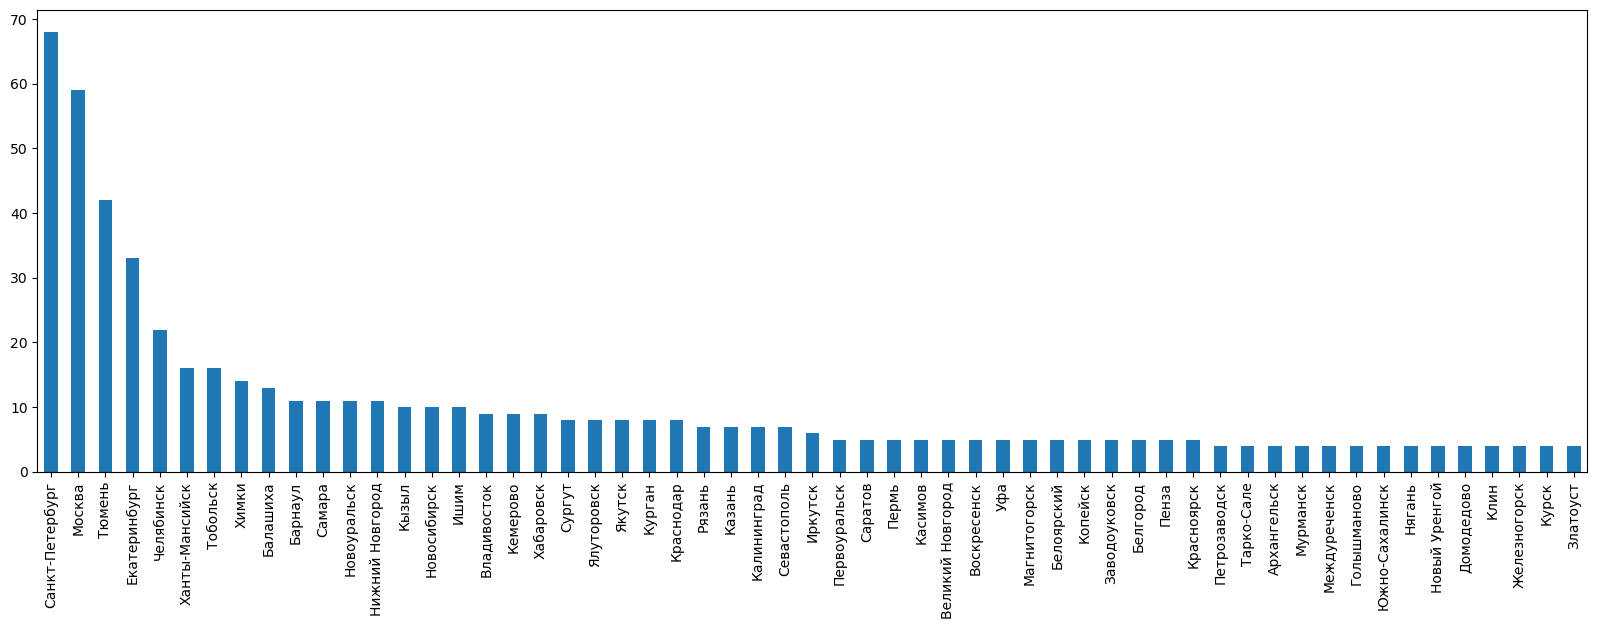

In [75]:
df['Город'].value_counts()[df['Город'].value_counts() > 3].plot(kind='bar', figsize=(20,6), rot = 90)

## Вывод: часть 1 выполнена
    - с сайта https://www.prlib.ru/mp 
    - сформированы ссылки, по которым выгружены атрибуты
    - построен график распредления ЦОД по городам, где ЦОД > 3

<a id="part-2"></a>
## Часть 2. NLP

Загружу датасет с отзывами на фильмы с сайта IMDB: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- Файл "IMDB Dataset.csv"

In [76]:
df = pd.read_csv("IMDB Dataset.csv")

In [77]:
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [79]:
df = df.drop_duplicates()

In [80]:
df['sentiment'].value_counts(dropna=False)

positive    24884
negative    24698
Name: sentiment, dtype: int64

In [81]:
df['sentiment'].value_counts(dropna=False, normalize=True)

positive    0.501876
negative    0.498124
Name: sentiment, dtype: float64

Датасет сбалансирован по классам. 

Заменю текстовое название классов числовым обозначением.
 - "positive" = 1,
 - "negative" = 0

In [82]:
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})

In [83]:
df['review'] = df['review'].str.replace('<br />', '') #заменяет '<br />' на ''

### 2.1. Разобью собранные данные на train/test

"Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования."

In [84]:
random_state = 42

In [85]:
X_text_train, X_text_test, y_train, y_test = train_test_split(df.drop(columns='sentiment'), 
                                                              df['sentiment'], 
                                                              test_size=0.2, 
                                                              random_state=random_state)

In [86]:
print(X_text_train.shape)
X_text_train.head(3)

(39665, 1)


review
7837   I really liked the movie 'The Emporer's New Gr...
4814   I decided to watch this movie because it has b...
35458  It's very hard to say just what was going on w...

In [87]:
print(X_text_test.shape)
X_text_test.head(3)

(9917, 1)


review
29171  "Soul Plane" is a horrible attempt at comedy t...
43589  Guest from the Future tells a fascinating stor...
38712  "National Treasure" (2004) is a thoroughly mis...

In [88]:
print(y_train.shape)
y_train.head(3)

(39665,)


7837     0
4814     0
35458    1
Name: sentiment, dtype: int64

In [89]:
print(y_test.shape)
y_test.head(3)

(9917,)


29171    0
43589    1
38712    0
Name: sentiment, dtype: int64

### 2.2. Применю tf-idf преобразование для текстового описания. <br>

"Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена."

TF-IDF (Term Frequency-Inverse Document Frequency) — это метод векторизации текста, который используется для представления документов в виде числовых векторов. Он основан на двух метриках: частоте термина в документе и обратной частоте термина во всем корпусе документов.

Метод TF-IDF вычисляет коэффициент между каждой парой термин-документ, где термин — это слово или фраза, а документ — это набор слов или фраз. Коэффициент вычисляется как произведение частоты термина в документе и обратной частоты термина во всем корпусе документов. Термины с более высоким коэффициентом имеют большее значение в документе, чем термины с низким коэффициентом.

TfidfVectorizer из библиотеки scikit-learn предоставляет реализацию метода TF-IDF для векторизации текстовых данных. Он может использоваться для создания матрицы терм-документ, которая может быть использована для классификации, кластеризации или других задач обработки текста.

Создаю экземпляр класса `TfidfVectorizer` из библиотеки scikit-learn.

Передаю несколько аргументов в конструктор `TfidfVectorizer`:

- lowercase: приводит все слова к нижнему регистру (True)
- stop_words: список стоп-слов, которые будут исключены из анализа ('english')
- ngram_range: диапазон значений n-грамм ((1, 2))
- max_df: максимальная доля документов, в которых слово может появляться, чтобы быть включенным в словарь (0.99)
- min_df: минимальная доля документов, в которых слово должно появляться, чтобы быть включенным в словарь (0.01)
- max_features: максимальное количество признаков (слов), которые будут использоваться (None)
- norm: тип нормализации для матрицы TF-IDF (None)

In [90]:
vectorizer = TfidfVectorizer(lowercase = True, 
                             stop_words ='english', 
                             ngram_range = (1, 2), 
                             max_df = 0.99, 
                             min_df = 0.01, 
                             max_features = None, 
                             norm = None)

После создания экземпляра `vectorizer`, использую его методы `fit_transform()` и `transform()` для преобразования текстовых данных в числовые векторы. Метод `fit_transform()` используется для обучения модели на тренировочных данных, а метод `transform()` используется для преобразования новых текстовых данных в числовые векторы.

In [91]:
X_train = vectorizer.fit_transform(X_text_train.review)
X_test = vectorizer.transform(X_text_test.review)

In [92]:
X_train.todense()[:1]

matrix([[6.000078, 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

### 2.3-2.4 Обучаю и настраиваю логистическую регрессию

"Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.
Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик."

Кросс-валидация модели логистической регрессии с использованием GridSearchCV для поиска наилучших параметров модели. 

KFold используется для разбиения данных на 5 фолдов (частей) и перемешивания их перед разбиением, чтобы уменьшить вероятность переобучения. 

In [93]:
folds = KFold(n_splits = 5, shuffle = True, random_state=random_state)

parameters содержит список параметров, которые будут использоваться для поиска наилучшей модели. 

'penalty' - это параметр, который определяет тип регуляризации (штрафа) для модели. В данном случае, мы рассматриваем 4 варианта: l2, l1, none, elasticnet.
'C' - это параметр регуляризации, который контролирует силу штрафа. Мы используем значения от 0.1 до 1.0 с шагом 0.1
max_iter - количество итераций (max_iter) для алгоритма оптимизации

Таким образом, GridSearchCV будет искать наилучшую модель среди всех возможных комбинаций значений 'penalty', 'C', 'max_iter'

In [94]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': list(np.arange(0.1, 1.1, 0.1)),
              'max_iter': [500, 1000, 5000]}

model - это модель логистической регрессии с заданным random_state. 

In [95]:
model = LogisticRegression(random_state = random_state)

model_grid - это объект GridSearchCV, который будет использоваться для поиска наилучших параметров модели. Он использует параметры model и parameters, а также scoring = 'f1', чтобы оценить производительность модели.  

In [96]:
model_grid = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1', cv = folds)

fit() выполняет поиск наилучшей модели с использованием x_train и y_train в качестве данных для обучения.

In [97]:
model_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                               0.7000000000000001, 0.8, 0.9, 1.0],
                         'max_iter': [500, 1000, 5000],
                         'penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='f1')

In [98]:
print(f'Параметры лучшей модели: {model_grid.best_params_} F1-score лучшей модели: {model_grid.best_score_:.3f}')

Параметры лучшей модели: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2'} F1-score лучшей модели: 0.866


### 2.5. Визуализирую получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретирую результаты.

In [99]:
model = LogisticRegression(penalty = model_grid.best_params_['penalty'], 
                           C = model_grid.best_params_['C'], 
                           max_iter = model_grid.best_params_['max_iter'], 
                           random_state = random_state)
model.fit(X_train, y_train)
prediction = model.predict(X_test)

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4939
           1       0.86      0.88      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



In [100]:
df = pd.DataFrame({'coef': model.coef_.tolist()[0], 'words':vectorizer.get_feature_names_out()})

In [101]:
df.head(3)

coef  words
0 -0.017766     10
1  0.339159  10 10
2  0.044906    100

In [102]:
df = (df.reindex(df['coef'].abs().sort_values(ascending=False).index)[:50].sort_values(by = 'coef'))

In [103]:
df

coef             words
1617 -0.440335             worst
1565 -0.428000             waste
114  -0.363327             awful
377  -0.327634    disappointment
1194 -0.324185         redeeming
1110 -0.310673            poorly
408  -0.304878              dull
808  -0.285215         laughable
920  -0.280538          mediocre
162  -0.276283            boring
483  -0.268549             fails
1446 -0.264008          terrible
109  -0.251011             avoid
1064 -0.246564          pathetic
691  -0.238922          horrible
799  -0.237933             lacks
801  -0.235946              lame
1616 -0.235319             worse
1109 -0.233005              poor
1105 -0.229811         pointless
118  -0.228757               bad
932  -0.221863              mess
1567 -0.219145            wasted
70   -0.210451          annoying
376  -0.202685     disappointing
123  -0.197817             badly
1242 -0.190462              save
1338 -0.186939             sorry
503   0.186623          favorite
1331  0.191483             solid
1069  0.193848         perfectly
1480  0.195233          touching
440   0.195243         enjoyable
581   0.196655          funniest
676   0.196885         hilarious
675   0.204752  highly recommend
875   0.206906             loved
174   0.207409         brilliant
1068  0.209530           perfect
1605  0.219673         wonderful
1397  0.220116            subtle
627   0.221462             great
1046  0.224080       outstanding
495   0.224691         fantastic
590   0.227771               gem
1406  0.240257            superb
1606  0.245476       wonderfully
60    0.248112           amazing
461   0.286199         excellent
1     0.339159             10 10

In [104]:
df.loc[df['coef'] >= 0].shape

(22, 2)

In [105]:
df.loc[df['coef'] < 0].shape

(28, 2)

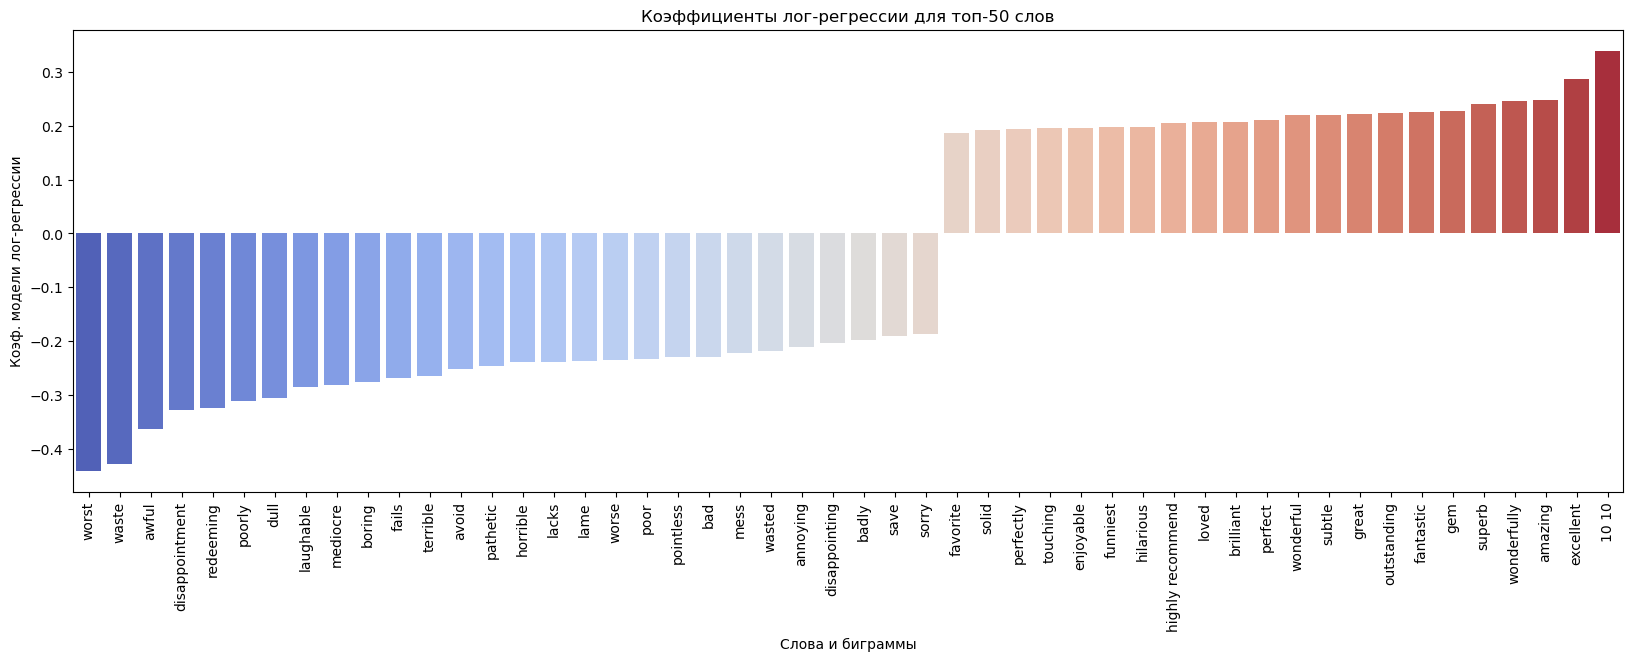

In [106]:
plt.figure(figsize = (20, 6))
ax = sns.barplot(x = df['words'], y = df['coef'], palette = 'coolwarm')
ax.set(xlabel = 'Слова и биграммы', 
       ylabel = 'Коэф. модели лог-регрессии', 
       title = 'Коэффициенты лог-регрессии для топ-50 слов')
plt.xticks(rotation = 90)
plt.show()

## Вывод: часть 2 выполнена
- Распределение слов ожидаемое, <br>
- для негативных отзывов наибольшие веса имеют слова `worst, waste, awful, poorly, disappointment`, <br>
- для позитивных отзывов наибольшие веса имеют слова `10 10, excellent, gem, highly recommend, wonderfully`, <br>
- В целом главных индикаторов негативных отзывов гораздо больше - 28 против 22. <br>